In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

In [19]:
face_images = glob.glob('lfw/**/*.jpg')

all_images = []

for i in tqdm(face_images):
  img = image.load_img(i, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  all_images.append(img)

100%|███████████████████████████████████| 13233/13233 [00:08<00:00, 1489.69it/s]


In [20]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=47, test_size=0.1)

In [21]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [22]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [23]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [24]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [25]:
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 80, 80, 256)       7168      
                                                                 
 conv2d_15 (Conv2D)          (None, 80, 80, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 40, 40, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 40, 40, 64)        73792     
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 64)        36928     
                                                           

1/1 [==============================] - 0s 69ms/step


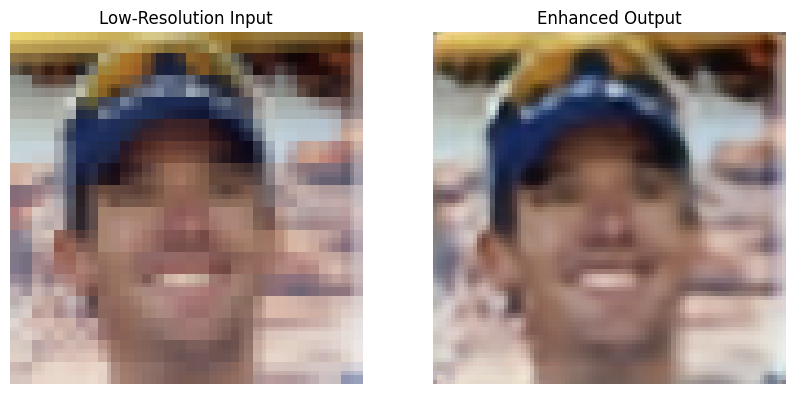

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.preprocessing import image

# Load the trained autoencoder model
autoencoder = load_model('autoencoder_model.h5')

# Function to enhance a single image
def enhance_image(image_path, scale_percent=40):
    # Load the image
    img = image.load_img(image_path, target_size=(80, 80, 3))
    img = image.img_to_array(img)
    img = img / 255.

    # Pixelate the image
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    # Scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
    low_res_image = cv2.resize(small_image, dim, interpolation=cv2.INTER_AREA)

    # Enhance the image using the autoencoder model
    enhanced_image = autoencoder.predict(np.array([low_res_image]))

    return low_res_image, enhanced_image[0]

# Provide the path to the image you want to enhance
input_image_path = '/Users/manvithchandra/Desktop/img.png'

# Enhance the image
low_res, enhanced = enhance_image(input_image_path)

# Plot the original low-resolution image and the enhanced image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Low-Resolution Input')
plt.imshow(low_res)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced Output')
plt.imshow(enhanced)
plt.axis('off')

plt.show()
